In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import sqlite3
import json

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


## Read in data

read in station name

In [4]:
df = pd.read_json('../ML_data_JJA.json')

## clean data

In [5]:
from datetime import datetime
dataset = df[['STN','ST','DATETIME','H','Temp','P','Vm','Vmsat']]

df_index = (dataset['DATETIME']>datetime(2015,1,1,0)) & (dataset['DATETIME']<datetime(2020,1,1,0))
dataset = dataset[df_index]

#stnlist=['新竹浮標','龜山島浮標','臺東外洋浮標','龍洞浮標','小琉球浮標','花蓮浮標','東沙島浮標','馬祖浮標']
#stnlist=['東沙島浮標']
#stnlist=['新竹浮標','臺東外洋浮標','東沙島浮標','馬祖浮標']
stnlist=['臺東外洋浮標','東沙島浮標','馬祖浮標']

dataset = dataset[dataset['STN'].isin(stnlist)]
dataset = dataset.dropna()

In [6]:
dataset.isna().sum()

STN         0
ST          0
DATETIME    0
H           0
Temp        0
P           0
Vm          0
Vmsat       0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [7]:
dataset = dataset.dropna()
dataset.tail()

,STN,ST,DATETIME,H,Temp,P,Vm,Vmsat
874189,馬祖浮標,C6W08,2018-08-30 20:00:00,1.72,27.5,1011.3,7.1,8.688476
874195,馬祖浮標,C6W08,2018-08-31 02:00:00,1.33,27.5,1011.3,6.6,7.444074
874201,馬祖浮標,C6W08,2018-08-31 08:00:00,0.97,27.5,1012.3,5.8,7.620192
874207,馬祖浮標,C6W08,2018-08-31 14:00:00,0.91,27.5,1010.7,7.4,6.952201
874213,馬祖浮標,C6W08,2018-08-31 20:00:00,0.92,27.2,1011.7,6.8,8.044406


<Figure size 3200x1600 with 0 Axes>

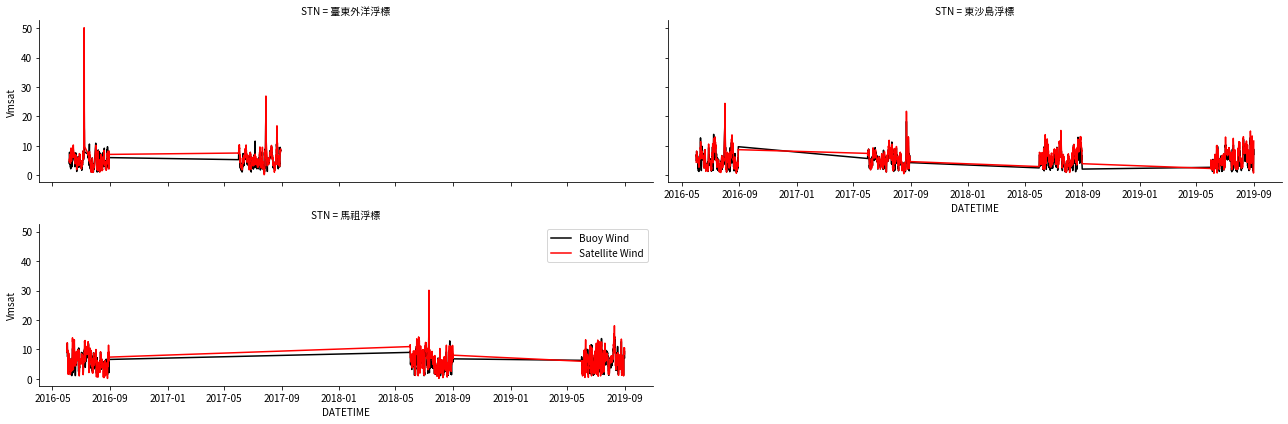

In [8]:
%matplotlib inline
plt.figure(figsize=(16,8),dpi=200)
g = sns.FacetGrid(dataset, col="STN", col_wrap=2, height=3, aspect=3)
g.map(sns.lineplot, 'DATETIME','Vm',color='k')
g.map(sns.lineplot, 'DATETIME','Vmsat',color='r')
plt.legend(labels=['Buoy Wind','Satellite Wind'])

In [9]:
dataset.pop('DATETIME')
dataset.pop('ST')
dataset.pop('STN')

151030    臺東外洋浮標
151036    臺東外洋浮標
151042    臺東外洋浮標
151048    臺東外洋浮標
151054    臺東外洋浮標
           ...  
874189      馬祖浮標
874195      馬祖浮標
874201      馬祖浮標
874207      馬祖浮標
874213      馬祖浮標
Name: STN, Length: 2993, dtype: object

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of your models.

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

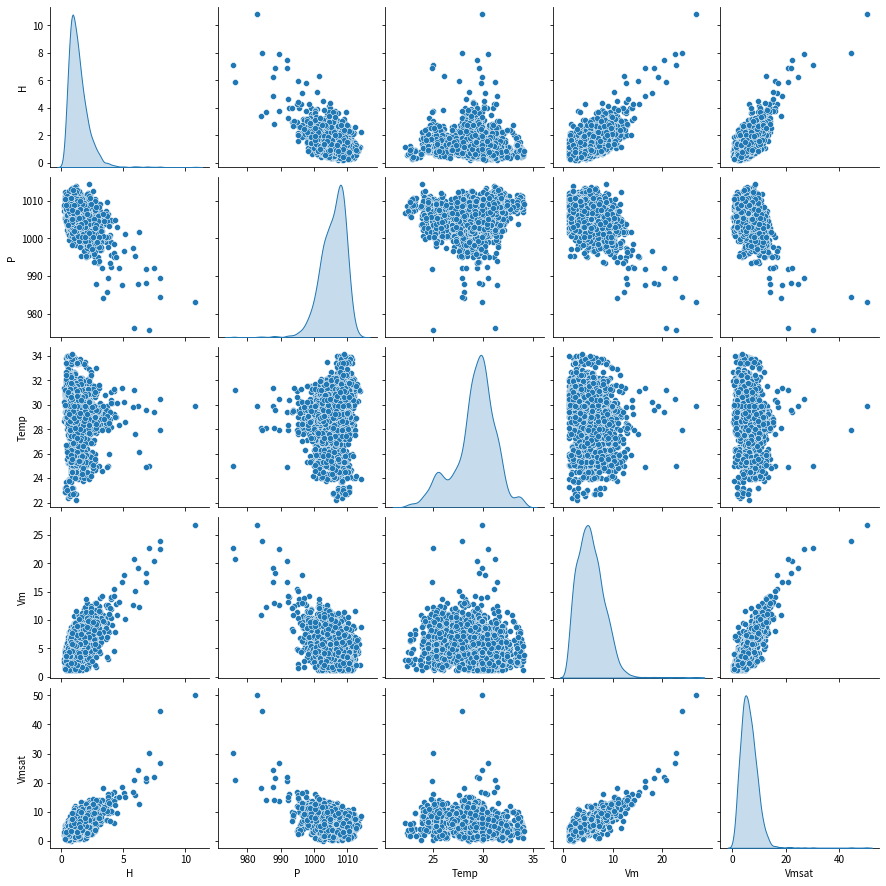

In [11]:
sns.pairplot(train_dataset[['H', 'P', 'Temp', 'Vm','Vmsat']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [12]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
H,2394.0,1.400789,0.828046,0.230000,0.85000,1.225000,1.740000,10.830000
Temp,2394.0,29.153926,2.052508,22.200000,28.30000,29.500000,30.400000,34.100000
P,2394.0,1005.697536,3.849774,975.700000,1003.40000,1006.300000,1008.500000,1014.300000
Vm,2394.0,5.594194,2.733343,1.100000,3.60000,5.300000,7.200000,26.800000
Vmsat,2394.0,6.171065,3.194736,0.168848,4.05566,5.807255,7.870123,50.117094


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [13]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('H')
test_labels = test_features.pop('H')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
H,1.400789,0.828046
Temp,29.153926,2.052508
P,1005.697536,3.849774
Vm,5.594194,2.733343
Vmsat,6.171065,3.194736


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable.

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [15]:
normalizer = preprocessing.Normalization(axis=-1)

Then `.adapt()` it to the data:

In [16]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [17]:
print(normalizer.mean.numpy())

[  29.154 1005.698    5.594    6.171]


When the layer is called it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[  29.9 1008.4    3.6    4.3]]

Normalized: [[ 0.36  0.7  -0.73 -0.59]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `H` from `Vmsat`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `Vmsat`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [19]:
Vm = np.array(train_features['Vm'])

Vm_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
Vm_normalizer.adapt(Vm)

Build the sequential model:

In [20]:
Vm_model = tf.keras.Sequential([
    Vm_normalizer,
    layers.Dense(units=1)
])

Vm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `H` from `Vms`.

Run the untrained model on the first 10 Vm values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [21]:
Vm_model.predict(Vm[:10])

array([[-0.767],
       [ 1.963],
       [-0.113],
       [-0.267],
       [-0.651],
       [ 0.118],
       [-1.036],
       [ 1.04 ],
       [-0.459],
       [-1.19 ]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [22]:
Vm_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [23]:
%%time
history = Vm_model.fit(
    train_features['Vm'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 20s, sys: 10min 1s, total: 11min 21s
Wall time: 20.2 s


Visualize the model's training progress using the stats stored in the `history` object.

In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.442505,0.456456,95
96,0.445207,0.459008,96
97,0.444020,0.456211,97
98,0.449571,0.488098,98
99,0.443196,0.461955,99


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error [H]')
  plt.legend()
  plt.grid(True)

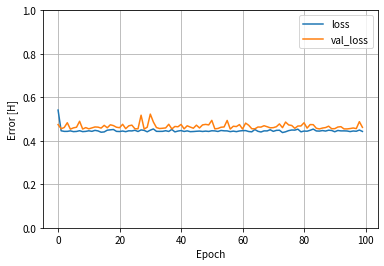

In [26]:
plot_loss(history)

Collect the results on the test set, for later:

In [27]:
test_results = {}

test_results['Vm_model'] = Vm_model.evaluate(
    test_features['Vm'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [28]:
x = tf.linspace(0.0, 20, 251)
y = Vm_model.predict(x)

In [29]:
def plot_Vm(x, y):
  plt.scatter(train_features['Vm'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Vm')
  plt.ylabel('H')
  plt.legend()

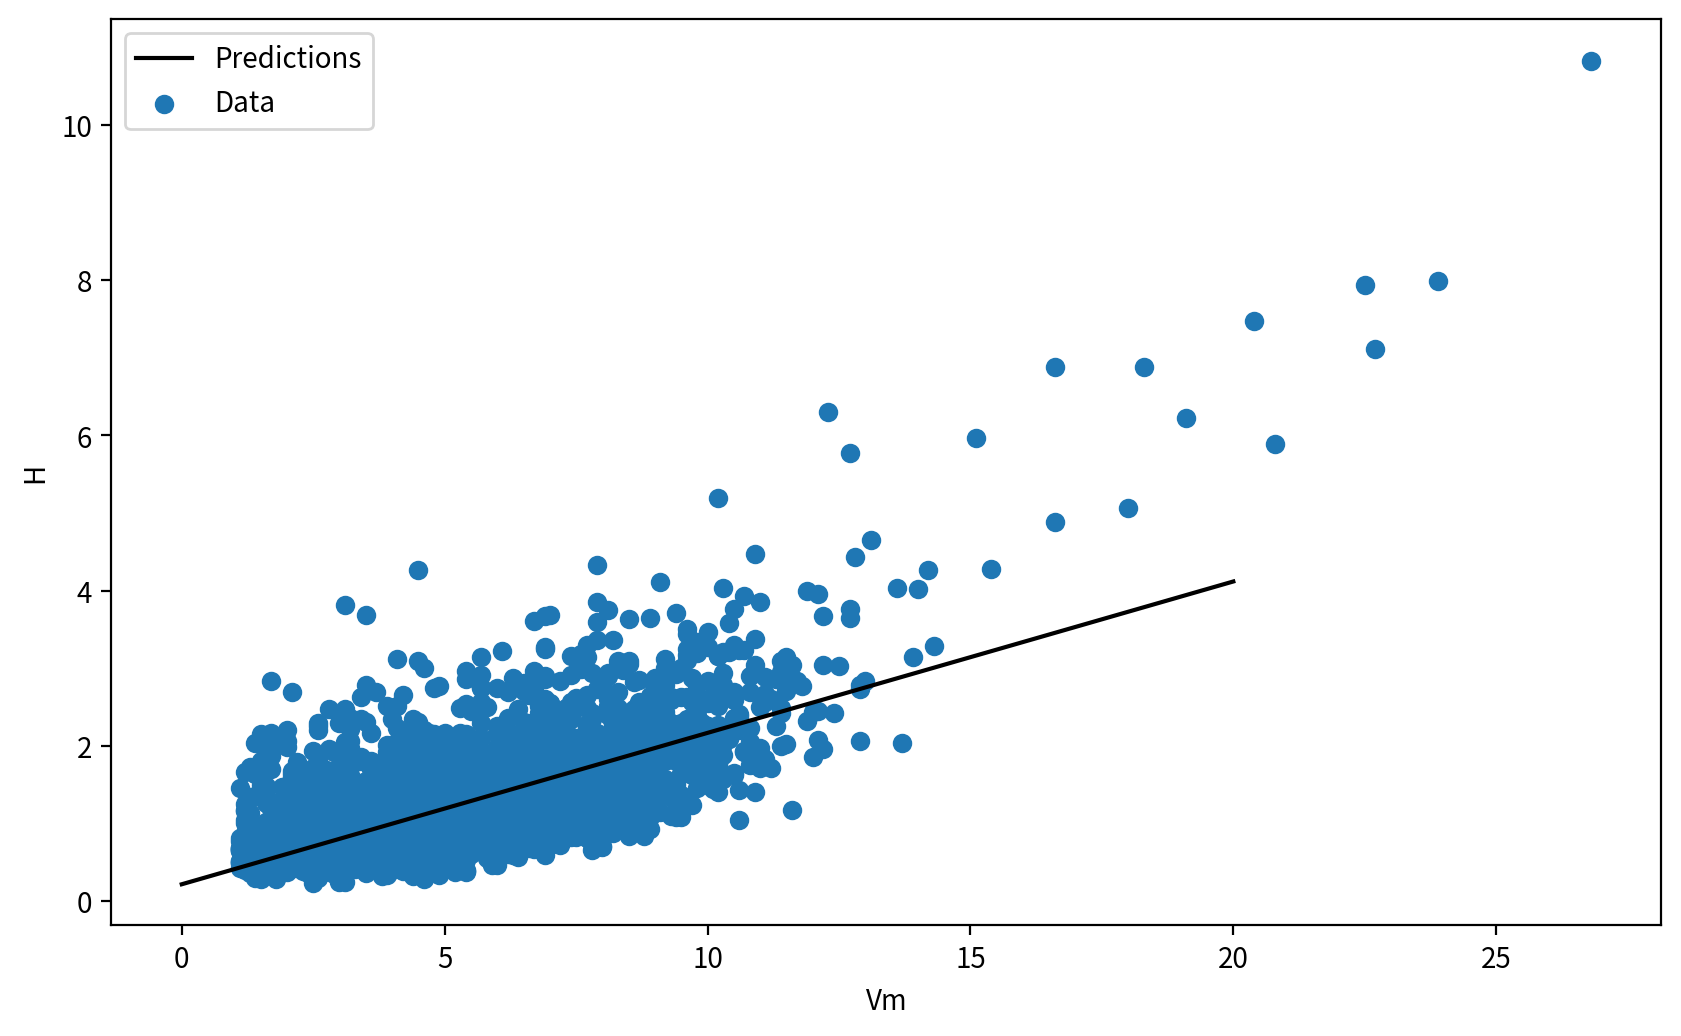

In [30]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vm(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [31]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [32]:
linear_model.predict(train_features[:10])

array([[-0.619],
       [ 1.777],
       [-0.509],
       [ 0.629],
       [ 0.659],
       [-1.215],
       [ 1.376],
       [-0.188],
       [ 0.197],
       [-0.435]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(4,1)`.

In [33]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.424],
       [-0.784],
       [ 0.561],
       [-0.318]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `Vmsat` model:

In [34]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [35]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 1min 19s, sys: 9min 45s, total: 11min 5s
Wall time: 19.4 s


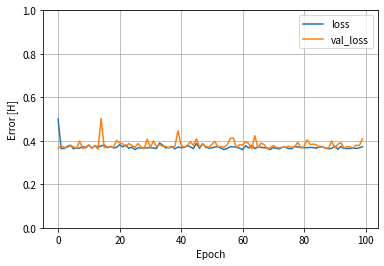

In [36]:
plot_loss(history)

In [37]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [38]:
x = tf.linspace(0.0, 50, 251)
y = linear_model.predict(pd.DataFrame(x))

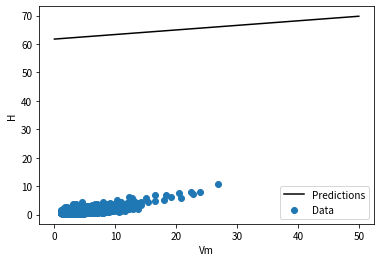

In [39]:
plot_Vm(x,y)

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.443485
linear_model,0.401784


## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [41]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Vmsat"

In [42]:
dnn_Vm_model = build_and_compile_model(Vm_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [43]:
dnn_Vm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [44]:
%%time
history = dnn_Vm_model.fit(
    train_features['Vm'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 58s, sys: 15min 48s, total: 17min 46s
Wall time: 39.6 s


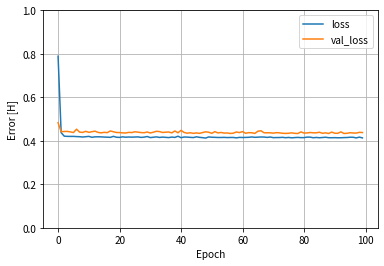

In [45]:
plot_loss(history)

In [46]:
x = tf.linspace(0.0, 20, 251)
y = dnn_Vm_model.predict(x)

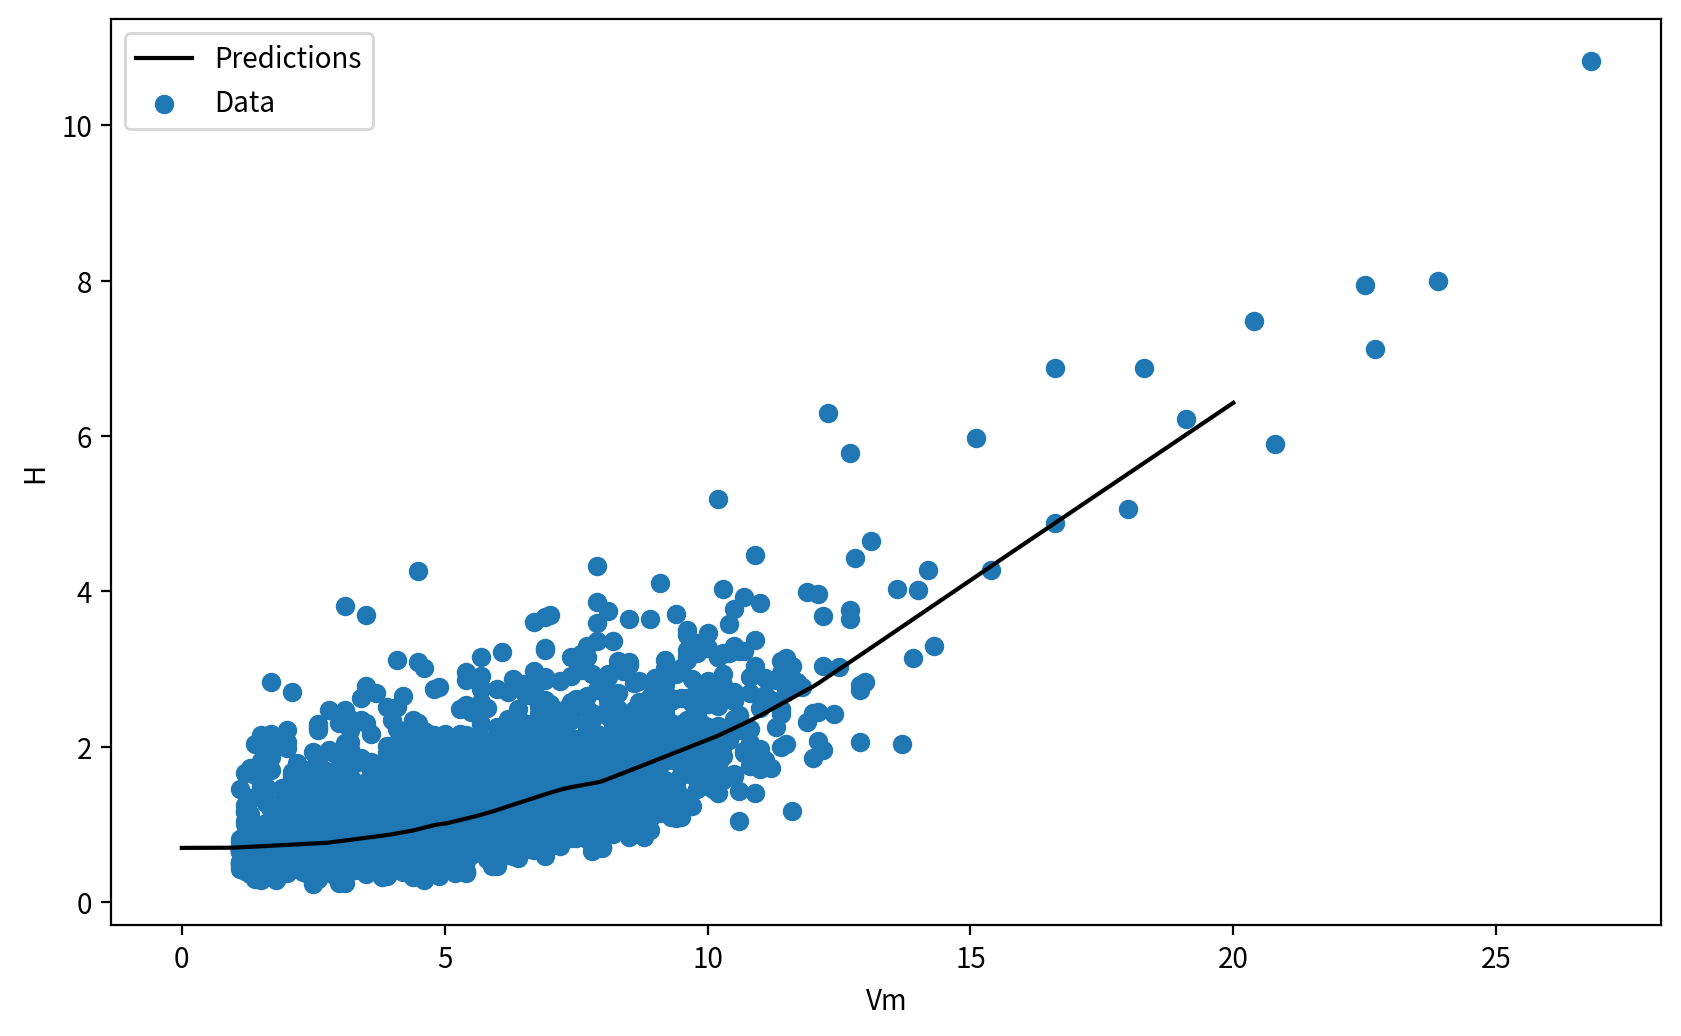

In [47]:
plt.figure(figsize=(10,6),dpi=200)
plot_Vm(x,y)

In [48]:
test_results['dnn_Vm_model'] = dnn_Vm_model.evaluate(
    test_features['Vm'], test_labels,
    verbose=0)

In [49]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.443485
linear_model,0.401784
dnn_Vm_model,0.426562


### Full model

In [50]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [51]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 1min 21s, sys: 11min 37s, total: 12min 58s
Wall time: 38.4 s


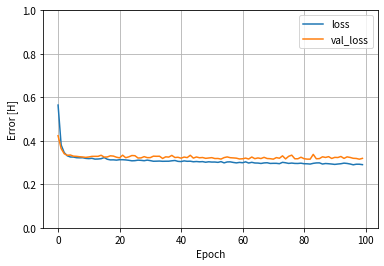

In [52]:
plot_loss(history)

In [53]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [54]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.443485
linear_model,0.401784
dnn_Vm_model,0.426562
dnn_model,0.317888


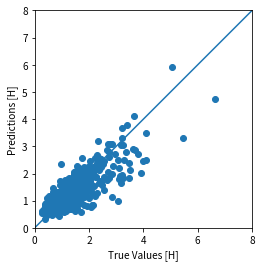

In [55]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


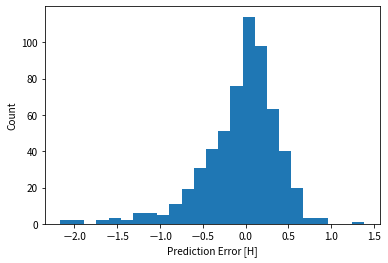

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

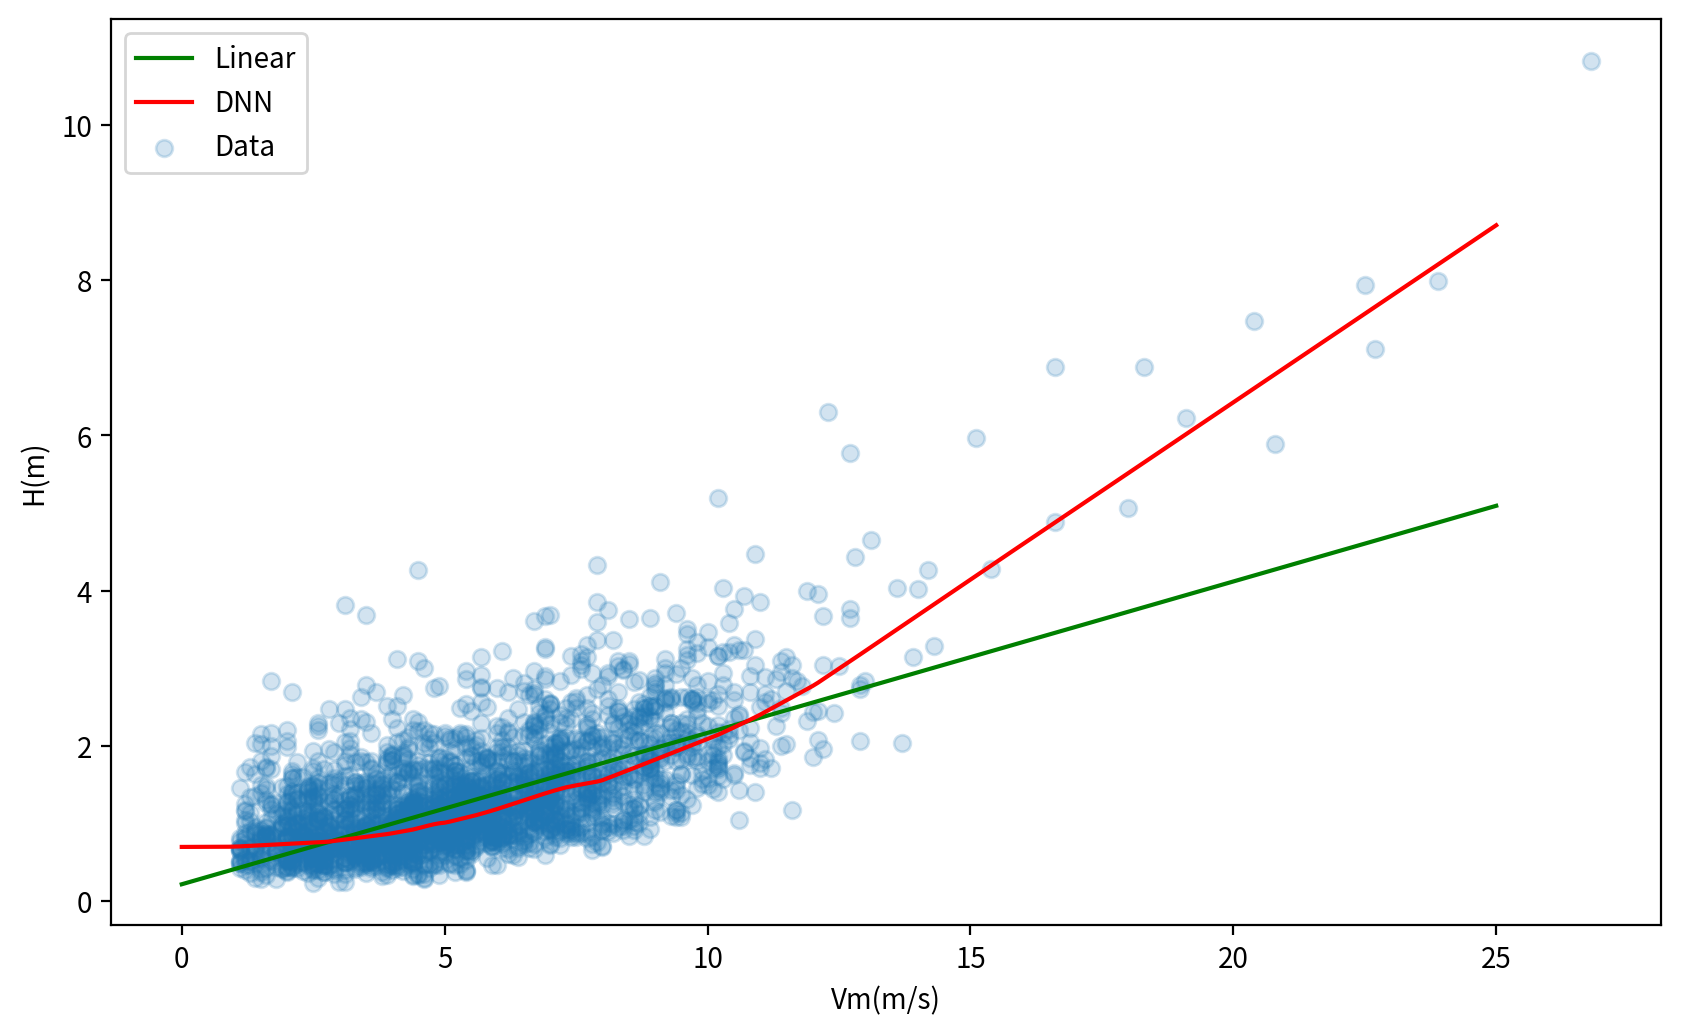

In [57]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
#y1 = dnn_model.predict(x)
y2 = dnn_Vm_model.predict(x)
y4 = Vm_model.predict(x)

plt.scatter(train_features['Vm'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.xlabel('Vm(m/s)')
plt.ylabel('H(m)')
plt.legend()

In [58]:
!mkdir -p saved_model

In [59]:
linear_model.save('saved_model/Vm_H_linear_model_JJA')
Vm_model.save(    'saved_model/Vm_H_Vm_model_JJA')
dnn_model.save(   'saved_model/Vm_H_dnn_model_JJA')
dnn_Vm_model.save('saved_model/Vm_H_dnn_Vm_model_JJA')

INFO:tensorflow:Assets written to: saved_model/Vm_H_linear_model_JJA/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_Vm_model_JJA/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_dnn_model_JJA/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_dnn_Vm_model_JJA/assets


# RNN

In [60]:
def build_and_compile_model_RNN(Norm):
  model = keras.Sequential([
      Norm,
      layers.SimpleRNN(64,  unroll=False, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
def build_and_compile_model_LSTM(Norm):
  model = keras.Sequential([
      Norm,
      layers.LSTM(64, input_shape=(1,1), activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [62]:
Vm_normalizer = preprocessing.Normalization(input_shape=[1,1], axis=None)
Vm_normalizer.adapt(Vm)

In [63]:
rnn_Vm_model = build_and_compile_model_RNN(Vm_normalizer)
#rnn_Vm_model = build_and_compile_model_LSTM(Vmsat_normalizer)

In [64]:
rnn_Vm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1, 1)              3         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [65]:
train_features['Vm'],train_labels

(495712     3.6
 503049    10.7
 496247     5.3
 504047     4.9
 503061     3.9
           ... 
 497234     4.3
 155785     5.7
 151318     3.5
 492453     2.4
 872579     7.7
 Name: Vm, Length: 2394, dtype: float64,
 495712    0.83
 503049    3.23
 496247    0.93
 504047    1.48
 503061    1.85
           ... 
 497234    1.96
 155785    0.92
 151318    1.55
 492453    0.80
 872579    0.88
 Name: H, Length: 2394, dtype: float64)

In [66]:
%%time
history = rnn_Vm_model.fit(
    train_features['Vm'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
60/60 [==============================] - 3s 20ms/step - loss: 1.2829 - val_loss: 0.7097
Epoch 2/100
60/60 [==============================] - 0s 7ms/step - loss: 0.6214 - val_loss: 0.4657
Epoch 3/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4306 - val_loss: 0.4485
Epoch 4/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4307 - val_loss: 0.4438
Epoch 5/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4200 - val_loss: 0.4428
Epoch 6/100
60/60 [==============================] - 0s 7ms/step - loss: 0.4272 - val_loss: 0.4423
Epoch 7/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4268 - val_loss: 0.4396
Epoch 8/100
60/60 [==============================] - 0s 6ms/step - loss: 0.4264 - val_loss: 0.4404
Epoch 9/100
60/60 [==============================] - 0s 6ms/step - loss: 0.4138 - val_loss: 0.4412
Epoch 10/100
60/60 [==============================] - 0s 6ms/step - loss: 0.4215 - val_loss: 0.4399
Epoch 11

Epoch 83/100
60/60 [==============================] - 1s 16ms/step - loss: 0.4235 - val_loss: 0.4348
Epoch 84/100
60/60 [==============================] - 1s 11ms/step - loss: 0.4017 - val_loss: 0.4350
Epoch 85/100
60/60 [==============================] - 1s 12ms/step - loss: 0.4015 - val_loss: 0.4356
Epoch 86/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4045 - val_loss: 0.4356
Epoch 87/100
60/60 [==============================] - 1s 8ms/step - loss: 0.4141 - val_loss: 0.4359
Epoch 88/100
60/60 [==============================] - 0s 5ms/step - loss: 0.4144 - val_loss: 0.4346
Epoch 89/100
60/60 [==============================] - 0s 8ms/step - loss: 0.4210 - val_loss: 0.4359
Epoch 90/100
60/60 [==============================] - 0s 5ms/step - loss: 0.4199 - val_loss: 0.4345
Epoch 91/100
60/60 [==============================] - 1s 9ms/step - loss: 0.4275 - val_loss: 0.4341
Epoch 92/100
60/60 [==============================] - 1s 13ms/step - loss: 0.4029 - val_loss: 0.4

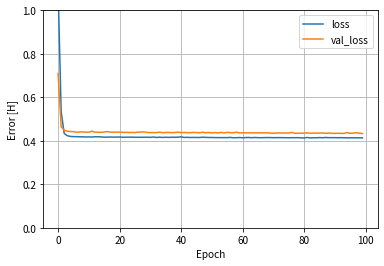

In [67]:
plot_loss(history)

In [68]:
test_results['rnn_Vm_model'] = rnn_Vm_model.evaluate(
    test_features['Vm'], test_labels,
    verbose=0)

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.443485
linear_model,0.401784
dnn_Vm_model,0.426562
dnn_model,0.317888
rnn_Vm_model,0.422815


### Multi-variable 

In [70]:
normalizer = preprocessing.Normalization(input_shape=[4,1], axis=None)
normalizer.adapt(np.array(train_features))

In [71]:
rnn_model = build_and_compile_model_RNN(normalizer)
rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_3 (Normalizati (None, 4, 1)              3         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                4224      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,292
Trainable params: 4,289
Non-trainable params: 3
_________________________________________________________________


In [72]:
%%time
history = rnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
60/60 [==============================] - 4s 26ms/step - loss: 1.0544 - val_loss: 0.5689
Epoch 2/100
60/60 [==============================] - 1s 18ms/step - loss: 0.5496 - val_loss: 0.5674
Epoch 3/100
60/60 [==============================] - 1s 21ms/step - loss: 0.5806 - val_loss: 0.5656
Epoch 4/100
60/60 [==============================] - 1s 22ms/step - loss: 0.5721 - val_loss: 0.5787
Epoch 5/100
60/60 [==============================] - 1s 18ms/step - loss: 0.5843 - val_loss: 0.5659
Epoch 6/100
60/60 [==============================] - 1s 15ms/step - loss: 0.5728 - val_loss: 0.5682
Epoch 7/100
60/60 [==============================] - 1s 14ms/step - loss: 0.5507 - val_loss: 0.5660
Epoch 8/100
60/60 [==============================] - 1s 11ms/step - loss: 0.5696 - val_loss: 0.5654
Epoch 9/100
60/60 [==============================] - 1s 13ms/step - loss: 0.5520 - val_loss: 0.5750
Epoch 10/100
60/60 [==============================] - 1s 16ms/step - loss: 0.5703 - val_loss: 0.5771

60/60 [==============================] - 1s 10ms/step - loss: 0.5642 - val_loss: 0.5617
Epoch 83/100
60/60 [==============================] - 1s 15ms/step - loss: 0.5798 - val_loss: 0.5615
Epoch 84/100
60/60 [==============================] - 1s 12ms/step - loss: 0.5749 - val_loss: 0.5644
Epoch 85/100
60/60 [==============================] - 1s 16ms/step - loss: 0.5601 - val_loss: 0.5613
Epoch 86/100
60/60 [==============================] - 1s 14ms/step - loss: 0.5658 - val_loss: 0.5610
Epoch 87/100
60/60 [==============================] - 1s 15ms/step - loss: 0.5697 - val_loss: 0.5616
Epoch 88/100
60/60 [==============================] - 1s 16ms/step - loss: 0.5835 - val_loss: 0.5638
Epoch 89/100
60/60 [==============================] - 1s 18ms/step - loss: 0.5457 - val_loss: 0.5629
Epoch 90/100
60/60 [==============================] - 1s 14ms/step - loss: 0.5470 - val_loss: 0.5611
Epoch 91/100
60/60 [==============================] - 1s 15ms/step - loss: 0.5698 - val_loss: 0.5603
Epo

In [73]:
test_results['rnn_model'] = rnn_model.evaluate(
    test_features, test_labels,
    verbose=0)

In [74]:
pd.DataFrame(test_results, index=['Mean absolute error [H]']).T

,Mean absolute error [H]
Vm_model,0.443485
linear_model,0.401784
dnn_Vm_model,0.426562
dnn_model,0.317888
rnn_Vm_model,0.422815
rnn_model,0.536459


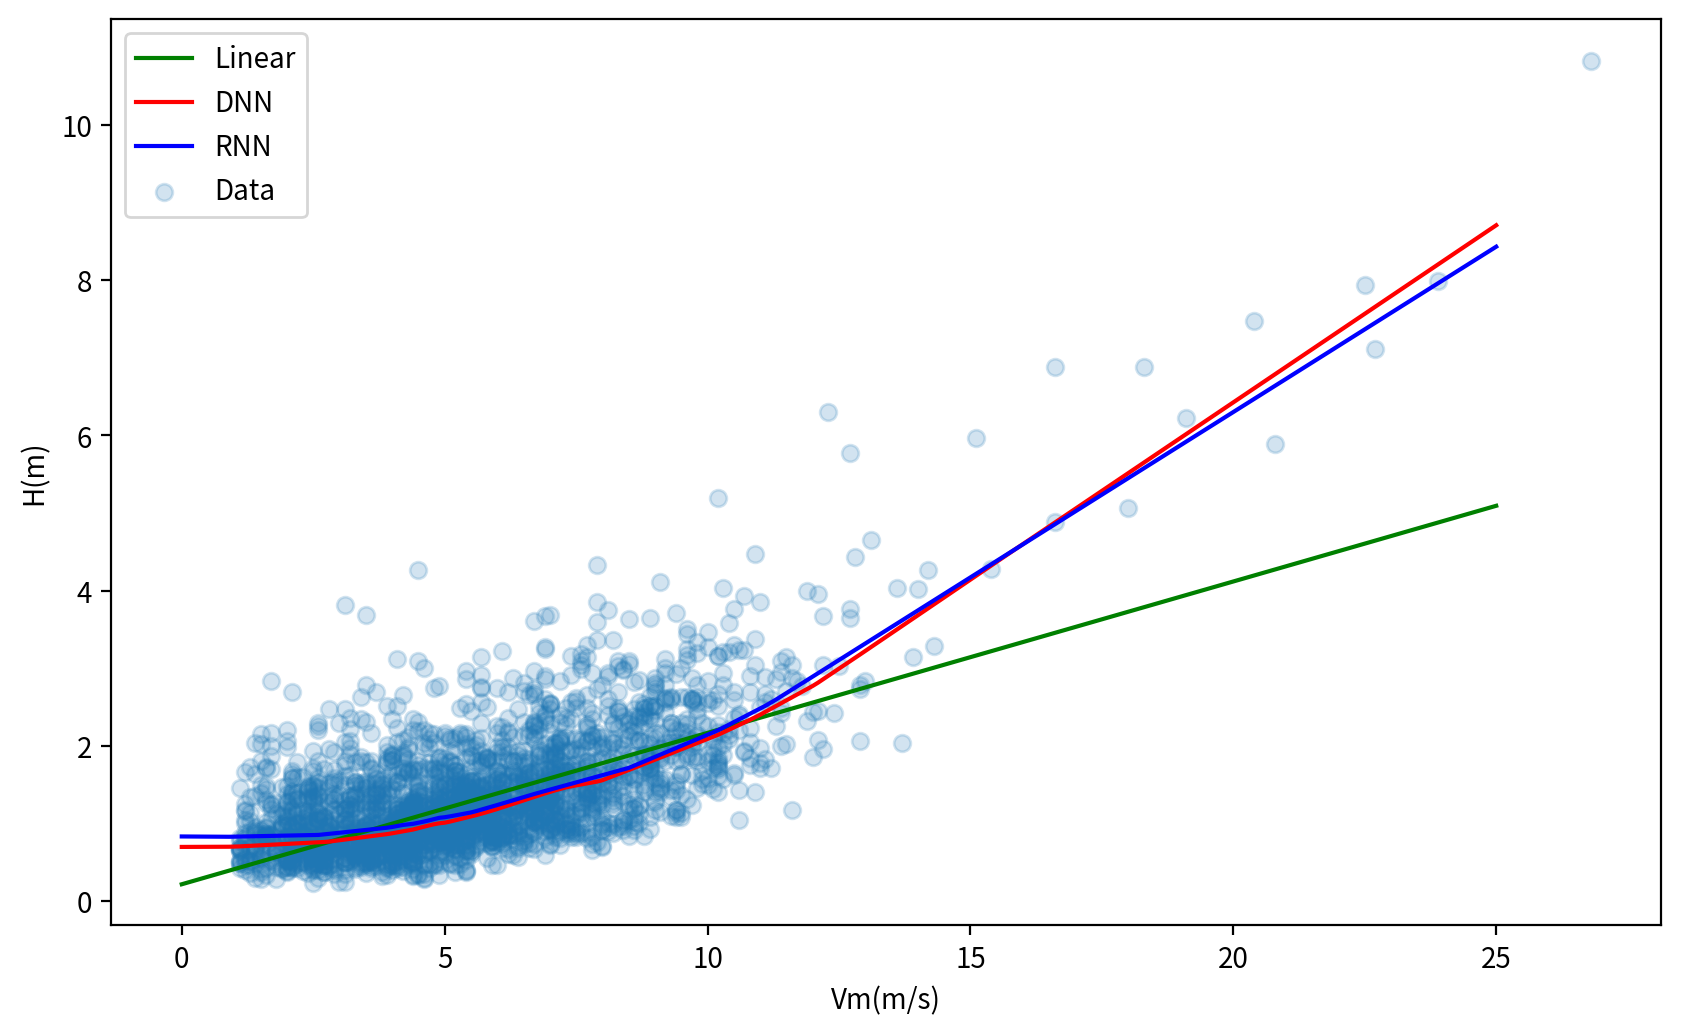

In [75]:
plt.figure(figsize=(10,6),dpi=200)
x = tf.linspace(0.0, 25, 251)
y1 = rnn_Vm_model.predict(x)
y2 = dnn_Vm_model.predict(x)
y4 = Vm_model.predict(x)

plt.scatter(train_features['Vm'], train_labels, label='Data',alpha=0.2)
#plt.plot(x, y1, color='b', label='DNN_multi')
#plt.plot(x, x, color='k')
plt.plot(x, y4, color='g', label='Linear')
plt.plot(x, y2, color='r', label='DNN')
plt.plot(x, y1, color='b', label='RNN')
plt.xlabel('Vm(m/s)')
plt.ylabel('H(m)')
plt.legend()

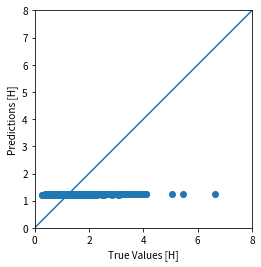

In [76]:
test_predictions = rnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [H]')
plt.ylabel('Predictions [H]')
lims = [0, 8]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


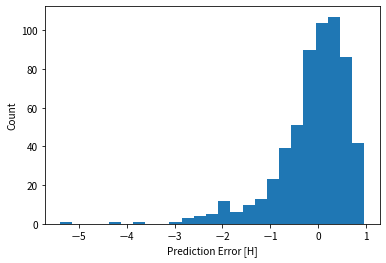

In [77]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [H]')
_ = plt.ylabel('Count')

In [78]:
rnn_model.save(   'saved_model/Vm_H_rnn_model_JJA')
rnn_Vm_model.save('saved_model/Vm_H_rnn_Vm_model_JJA')

INFO:tensorflow:Assets written to: saved_model/Vm_H_rnn_model_JJA/assets
INFO:tensorflow:Assets written to: saved_model/Vm_H_rnn_Vm_model_JJA/assets


## SVM

In [79]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [80]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

In [81]:
history = svr.fit(np.array(train_features['Vm']).reshape(-1,1), train_labels)

In [82]:
train_sizes, train_scores_svr, test_scores_svr = learning_curve(
    svr,
    np.array(test_features['Vm']).reshape(-1,1),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

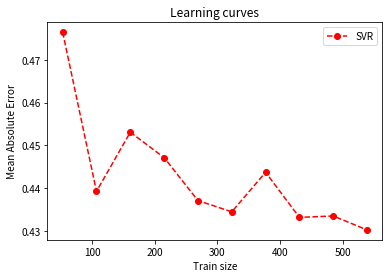

In [83]:
#plt.plot(train_sizes, -test_scores_kr.mean(1), "o--", color="g", label="KRR")
plt.plot(train_sizes, -test_scores_svr.mean(1), "o--", color="r", label="SVR")
plt.xlabel("Train size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning curves")
plt.legend(loc="best")

In [84]:
-test_scores_svr.mean(1)

array([0.476, 0.439, 0.453, 0.447, 0.437, 0.434, 0.444, 0.433, 0.433,
       0.43 ])

In [85]:
svr.predict(np.array(train_features['Vm']).reshape(-1,1))

array([0.918, 2.407, 1.135, ..., 0.908, 0.836, 1.596])

In [86]:
import joblib
joblib.dump(svr, 'saved_model/Vm_H_svr_Vm_model_JJA')

['saved_model/Vm_H_svr_Vm_model_JJA']

In [87]:
svr2 = joblib.load("saved_model/Vm_H_svr_Vm_model_JJA")

In [88]:
svr2.predict(np.array(train_features['Vm']).reshape(-1,1))

array([0.918, 2.407, 1.135, ..., 0.908, 0.836, 1.596])

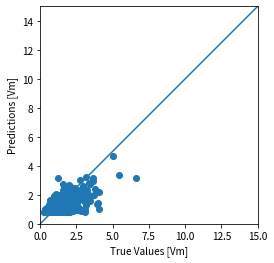

In [89]:
test_predictions = svr2.predict(np.asarray(test_features['Vm'])[:,None]).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

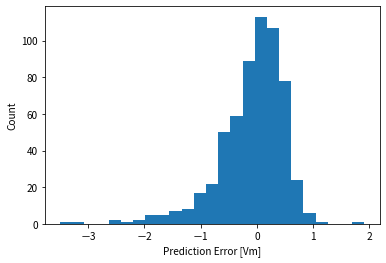

In [90]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')

## Multi-variable

In [91]:
history = svr.fit(np.array(train_features), train_labels)

In [92]:
train_sizes_mv, train_scores_svr_mv, test_scores_svr_mv = learning_curve(
    svr,
    np.array(test_features),
    test_labels,
    train_sizes=np.linspace(0.1, 1, 10),
    scoring="neg_mean_absolute_error",
    cv=10,
)

In [93]:
import joblib
joblib.dump(svr, 'saved_model/Vm_H_svr_model_JJA')

['saved_model/Vm_H_svr_model_JJA']

In [94]:
svr = joblib.load("saved_model/Vm_H_svr_model_JJA")

In [95]:
svr.predict(np.array(train_features))

array([0.835, 3.117, 0.909, ..., 0.894, 0.733, 1.452])

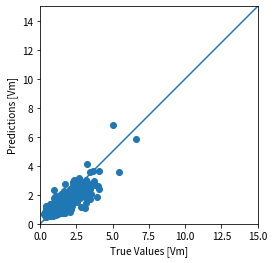

In [96]:
test_predictions = svr.predict(np.asarray(test_features)).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Vm]')
plt.ylabel('Predictions [Vm]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

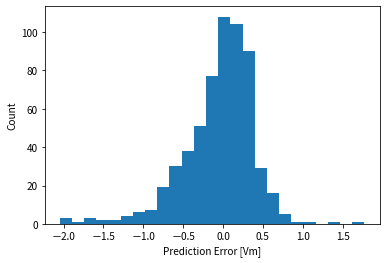

In [97]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Vm]')
_ = plt.ylabel('Count')

In [98]:
def svr_evaluate(test_features, test_labels):
    return np.mean(np.abs(test_features-test_labels))

In [99]:
svr_evaluate(svr.predict(np.array(test_features)),np.array(test_labels))

0.3200038593029601

In [100]:
np.abs(svr.predict(np.array(test_features))-np.array(test_labels))

array([0.227, 0.587, 0.794, 0.05 , 0.183, 0.307, 0.077, 0.07 , 0.372,
       0.06 , 0.109, 0.318, 0.071, 0.031, 0.116, 0.065, 0.205, 0.21 ,
       0.032, 0.053, 0.106, 0.086, 0.045, 0.157, 0.168, 0.166, 0.061,
       0.247, 0.026, 0.236, 0.086, 0.074, 0.029, 0.103, 0.112, 0.023,
       0.234, 0.736, 0.119, 0.093, 0.001, 0.009, 0.209, 0.266, 0.223,
       0.213, 0.291, 0.392, 0.351, 0.319, 0.23 , 0.367, 1.043, 0.007,
       0.254, 0.55 , 0.284, 0.024, 0.02 , 0.19 , 0.48 , 0.417, 0.552,
       0.456, 0.042, 0.545, 0.29 , 0.015, 0.205, 0.362, 0.028, 0.049,
       0.057, 0.067, 0.162, 0.093, 0.095, 0.033, 0.081, 0.165, 0.091,
       0.408, 0.093, 0.16 , 0.432, 0.125, 0.066, 0.176, 0.401, 0.067,
       0.03 , 0.128, 0.276, 0.623, 0.329, 0.134, 0.083, 0.162, 0.148,
       0.147, 0.314, 0.384, 0.365, 0.036, 0.058, 0.084, 0.086, 0.251,
       0.38 , 0.244, 1.773, 0.893, 1.756, 0.178, 0.045, 0.819, 0.375,
       0.296, 0.028, 0.175, 0.094, 0.815, 0.199, 0.11 , 0.243, 0.054,
       0.098, 0.021,